# Đề thi mẫu chứng chỉ TensorFlow - Dạng bài 05

```
ProtonX - TensorFlow Class
```
Giới thiệu về chứng chỉ - https://www.tensorflow.org/certificate

> Chú ý: đọc kỹ các nội dung trong Handle Notebook trong liên kết trên.

---

### Hướng dẫn làm bài

Một số yêu cầu:
- Sử dụng TensorFlow.

Tiêu chí chấm điểm:
- Yêu cầu MAE < 0.12




### Thực hiện

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/adib0073/TimeSeries-Using-TensorFlow/main/Data/Sunspots.csv \
    -O /tmp/sunspots.csv

/bin/bash: /home/danieldu/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
wget: /home/danieldu/anaconda3/lib/libuuid.so.1: no version information available (required by wget)
--2023-10-11 13:08:28--  https://raw.githubusercontent.com/adib0073/TimeSeries-Using-TensorFlow/main/Data/Sunspots.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/plain]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K   398KB/s    in 0.2s    

2023-10-11 13:08:29 (398 KB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



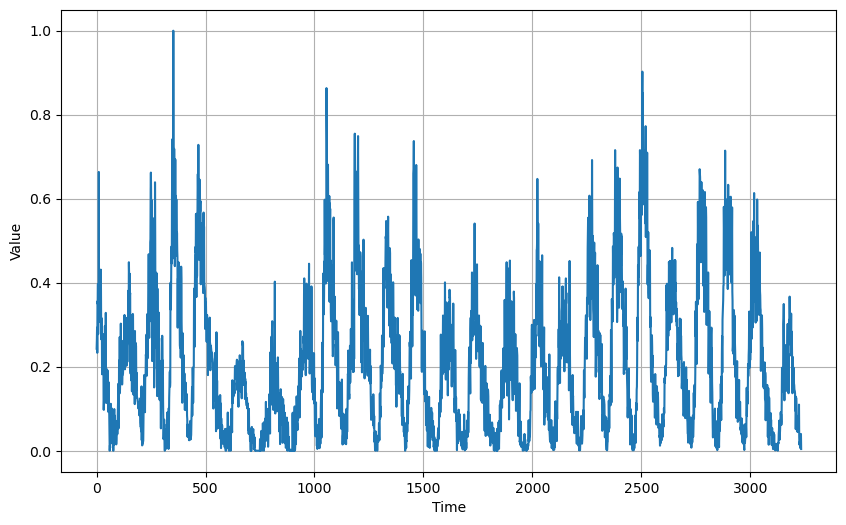

In [3]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
scaler = MinMaxScaler()
series = scaler.fit_transform(series.reshape(-1, 1))
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)
np.random.seed(0)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
test_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

2023-10-11 13:08:29.503480: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 13:08:29.503673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 13:08:29.527803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 13:08:29.527992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 13:08:29.528142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [6]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [1]:
import tensorflow as tf
tf.test.is_gpu_available() #should return True 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Num GPUs Available:  2


2023-10-11 13:11:09.031382: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 13:11:09.209711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 13:11:09.209892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 13:11:09.234256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [7]:


lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

history = model.fit(
    train_set,
    validation_data=(test_set),
    epochs=100,
    callbacks=[lr_schedule])

Epoch 1/100


2023-10-11 13:08:32.433704: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8500


: 

In [ ]:
# Lưu Model và nộp
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
rnn_forecast
model.save("sunspots_mymodel.h5")